In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

print(X_motion.shape)
print(Y_motion.shape)

(1562, 24)
(1562, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.23176558,  0.1293593 , -0.38014007,  0.25642681,
       -0.13292494, -0.3601585 , -0.24668945,  0.12215804, -0.36803153,
       -0.26760721, -0.12942849, -0.38008294,  0.08500251, -0.03102972,
       -0.06080959, -0.01363518,  1.        ,  0.        ])

In [16]:
X_motion_FL_swinging[10, 18:22]

array([ 0.08500251, -0.03102972, -0.06080959, -0.01363518])

In [9]:
Y_motion_FL_swinging.shape

(780, 4)

In [10]:
X_motion_FL_swinging[0:10, 0]

array([0. , 0.1, 0.1, 0. , 0. , 0.1, 0.1, 0. , 0. , 0.1])

### Linear Regression

In [29]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9880574318613469
RMSE:  0.01465339029589386
The lowest error is:  9.035494801071242e-05
The highest error is:  0.08085358125948824
The avg. error is:  0.010265283674608607


In [30]:
model_fl_relative_support_x.coef_

array([[ 3.90717503e-02, -1.11022302e-16,  4.71844785e-16,
         1.61295656e-01, -2.77555756e-16,  0.00000000e+00,
         2.46253526e-01,  2.42325365e-01, -1.10629505e+00,
         6.96867487e-02, -4.77819932e-02,  1.23889122e+00,
        -4.68189930e-01, -3.29380154e-01, -5.41779005e-01,
        -7.46933331e-01]])

In [31]:
model_fl_relative_support_x.intercept_

array([0.11899331])

Text(0, 0.5, 'Predictions')

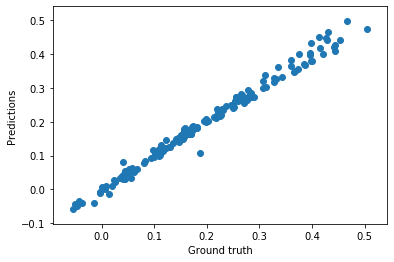

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [33]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5616595441543119
RMSE:  0.0067454584817013205
The lowest error is:  0.00010870796879788869
The highest error is:  0.021260699758532675
The avg. error is:  0.005051678029236619


In [34]:
model_fl_relative_support_y.coef_

array([[-1.66694828e-02,  2.74086309e-16, -5.37764278e-17,
        -8.98773404e-03,  2.22044605e-16,  0.00000000e+00,
         5.60185462e-02,  5.97089205e-02, -1.21075373e-01,
        -1.67501351e+00, -6.50610486e-02,  4.95510355e-01,
        -1.51957082e-01,  5.49379440e-01,  7.34727364e-02,
        -4.18357413e-01]])

In [35]:
model_fl_relative_support_y.intercept_

array([0.18013068])

Text(0, 0.5, 'Predictions')

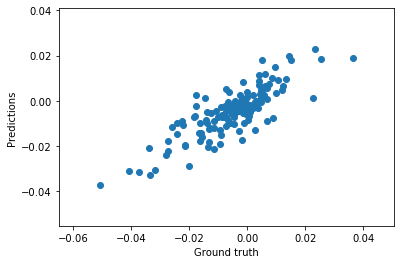

In [36]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [37]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')